In [8]:
import numpy as np
import pandas as pd

Features: 
* Time peak
  - Check time series distribution relative to perofrmance (pure stats) and see if there's any merit to the time of peak of a player.
* Formula (Raw Score & With Peak & Probability).
  - Come up with formula to calculate the raw score (with and without peak) and the probability of winning all-nba.
  - My theory is that we'll have to group and compare stats by position (guard, forward, and center). Then we ought to arrange all players that season and see their average standing to calculate for the weights.
  - Another theory is that the time of peak performance of a player has an effect on the likelihood that an nba player will be picked as an all-nba player.
  - Team-success should also be considered.
* Compare to average game score per season
  - Test statistical significance (Correlation or MSE) between game score and winning all-nba modell.
* Testing of accuracy
  - For the probability, we could test using MSE. With 1 being an All-NBA player and 0 if not.
  - Or arange them by their score (from derrived formula) that season and show accurate our list is based on the official all-nba. 

Problems
* Stats to consider
  - Different positions have different emphasis (guards are more considered valuable if they could facilitate while centers are more valuable for their defensive output)
  - The challenge here lies in how to get these emphasis
  - My theory is we could get this through averaging the stats of all-nba players and non all-nba players and rank them based on their deviations. The more deviation, the higher emphasis.
* Training Model for weights?
  - regression logistic
* Should we remove the classic era?
  - It is possible to identify three main Eras that we define as the Classic Era of the NBA (1980–1994), the Transitional Era of the NBA (1995–2013), and the Modern Era of the NBA (since 2013) ([link](https://content.iospress.com/articles/journal-of-sports-analytics/jsa200525))  

## ALL NBA ORIGINAL CSV

In [9]:
df_season_awards = pd.read_csv('End of Season Teams (Voting).csv')
df_all_nba = df_season_awards[df_season_awards['type']=='All-NBA']
df_all_nba.head(10)

,season,lg,type,number_tm,position,player,age,tm,pts_won,pts_max,share,x1st_tm,x2nd_tm,x3rd_tm,seas_id,player_id
34,2024,NBA,All-NBA,1T,C,Nikola Jokić,28,DEN,495.0,495.0,1.000,99.0,0.0,0.0,31672,4352
35,2024,NBA,All-NBA,1T,G,Shai Gilgeous-Alexander,25,OKC,495.0,495.0,1.000,99.0,0.0,0.0,31769,4670
36,2024,NBA,All-NBA,1T,G,Luka Dončić,24,DAL,493.0,495.0,0.996,98.0,1.0,0.0,31593,4654
37,2024,NBA,All-NBA,1T,F,Giannis Antetokounmpo,29,MIL,473.0,495.0,0.956,88.0,11.0,0.0,31366,4164
38,2024,NBA,All-NBA,1T,F,Jayson Tatum,25,BOS,427.0,495.0,0.863,65.0,34.0,0.0,31468,4518
39,2024,NBA,All-NBA,2T,G,Jalen Brunson,27,NYK,368.0,495.0,0.743,37.0,61.0,0.0,31429,4630
40,2024,NBA,All-NBA,2T,G,Anthony Edwards,22,MIN,285.0,495.0,0.576,3.0,87.0,9.0,31171,4808
41,2024,NBA,All-NBA,2T,F,Kevin Durant,35,PHO,274.0,495.0,0.554,2.0,85.0,9.0,31551,3770
42,2024,NBA,All-NBA,2T,F,Kawhi Leonard,32,LAC,242.0,495.0,0.489,1.0,72.0,21.0,31531,4032
43,2024,NBA,All-NBA,2T,C,Anthony Davis,30,LAL,230.0,495.0,0.465,1.0,65.0,30.0,31170,4066


## Stats Per Game Original

In [10]:
df_season_stats = df_season_awards = pd.read_csv('Player Per Game.csv')
df_season_stats.head()

,seas_id,season,player_id,player,birth_year,pos,age,experience,lg,tm,...,ft_percent,orb_per_game,drb_per_game,trb_per_game,ast_per_game,stl_per_game,blk_per_game,tov_per_game,pf_per_game,pts_per_game
0,31871,2025,5025,A.J. Green,NaN,SG,25.0,3,NBA,MIL,...,1.000,0.0,0.4,0.4,0.6,0.2,0.0,0.2,0.2,3.4
1,31872,2025,5210,AJ Johnson,NaN,SG,20.0,1,NBA,MIL,...,NaN,0.0,0.3,0.3,0.0,0.0,0.0,0.0,0.0,0.7
2,31873,2025,4219,Aaron Gordon,NaN,PF,29.0,11,NBA,DEN,...,0.857,3.3,4.3,7.5,3.5,1.0,0.5,2.0,2.0,15.5
3,31874,2025,4582,Aaron Holiday,NaN,PG,28.0,7,NBA,HOU,...,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,31875,2025,4805,Aaron Nesmith,NaN,SF,25.0,5,NBA,IND,...,0.846,0.8,3.8,4.6,1.0,0.8,0.4,0.8,4.8,8.6


In [11]:
print(df_season_awards.duplicated(subset=['season', 'player_id']).sum())
print(df_season_stats.duplicated(subset=['season', 'player_id']).sum())

6053
6053


### Combining Duplicated rows
as it turns out, players who were traded half-way have separate entry. Before we could proceed accordingly, it is imperative to combine them.

In [12]:
def weighted_mean(series, weights):
    return (series * weights).sum() / weights.sum()

aggregation_dict = {
    'mp_per_game': lambda x: weighted_mean(x, df_season_stats.loc[x.index, 'g']),   # Weighted minutes
    'fg_per_game': lambda x: weighted_mean(x, df_season_stats.loc[x.index, 'g']),   # Weighted field goals
    'fga_per_game': lambda x: weighted_mean(x, df_season_stats.loc[x.index, 'g']),  # Weighted field goal attempts
    'fg_percent': lambda x: weighted_mean(x, df_season_stats.loc[x.index, 'g']),    # Weighted FG%
    'x3p_per_game': lambda x: weighted_mean(x, df_season_stats.loc[x.index, 'g']),  # Weighted 3-pointers made
    'x3pa_per_game': lambda x: weighted_mean(x, df_season_stats.loc[x.index, 'g']), # Weighted 3-point attempts
    'x3p_percent': lambda x: weighted_mean(x, df_season_stats.loc[x.index, 'g']),   # Weighted 3P%
    'x2p_per_game': lambda x: weighted_mean(x, df_season_stats.loc[x.index, 'g']),  # Weighted 2-pointers made
    'x2pa_per_game': lambda x: weighted_mean(x, df_season_stats.loc[x.index, 'g']), # Weighted 2-point attempts
    'x2p_percent': lambda x: weighted_mean(x, df_season_stats.loc[x.index, 'g']),   # Weighted 2P%
    'e_fg_percent': lambda x: weighted_mean(x, df_season_stats.loc[x.index, 'g']),  # Weighted Effective FG%
    'ft_per_game': lambda x: weighted_mean(x, df_season_stats.loc[x.index, 'g']),   # Weighted free throws
    'fta_per_game': lambda x: weighted_mean(x, df_season_stats.loc[x.index, 'g']),  # Weighted free throw attempts
    'ft_percent': lambda x: weighted_mean(x, df_season_stats.loc[x.index, 'g']),    # Weighted FT%
    'orb_per_game': lambda x: weighted_mean(x, df_season_stats.loc[x.index, 'g']),  # Weighted offensive rebounds
    'drb_per_game': lambda x: weighted_mean(x, df_season_stats.loc[x.index, 'g']),  # Weighted defensive rebounds
    'trb_per_game': lambda x: weighted_mean(x, df_season_stats.loc[x.index, 'g']),  # Weighted total rebounds
    'ast_per_game': lambda x: weighted_mean(x, df_season_stats.loc[x.index, 'g']),  # Weighted assists
    'stl_per_game': lambda x: weighted_mean(x, df_season_stats.loc[x.index, 'g']),  # Weighted steals
    'blk_per_game': lambda x: weighted_mean(x, df_season_stats.loc[x.index, 'g']),  # Weighted blocks
    'tov_per_game': lambda x: weighted_mean(x, df_season_stats.loc[x.index, 'g']),  # Weighted turnovers
    'pf_per_game': lambda x: weighted_mean(x, df_season_stats.loc[x.index, 'g']),   # Weighted personal fouls
    'pts_per_game': lambda x: weighted_mean(x, df_season_stats.loc[x.index, 'g']),  # Weighted points
}

additional_aggregation = {
    'seas_id': 'first',  # Keep the first season ID
    'player': 'first',   # Keep the player's name
    'birth_year': 'first',  # Keep birth year
    'pos': 'first',  # Keep the first position
    'age': 'mean',   # Average age
    'experience': 'mean',  # Average experience
    'g': 'sum'       # Total games played
}

aggregation_dict.update(additional_aggregation)

# df_combined = df_season_stats.groupby(['season', 'player_id']).agg(aggregation_dict).reset_index()
# df_combined.head()

df_season_stats.dtypes

## Loading Fixed NBA Stats Per Game without duplicates


In [13]:
nba_stats_per_game = pd.read_csv('nba_per_game_no_duplicates.csv')
nba_stats_per_game

,season,player_id,mp_per_game,fg_per_game,fga_per_game,fg_percent,x3p_per_game,x3pa_per_game,x3p_percent,x2p_per_game,...,tov_per_game,pf_per_game,pts_per_game,seas_id,player,birth_year,pos,age,experience,g
0,1947,1,0.0,3.8,15.0,0.256,0.0,0.0,0.000,3.8,...,0.0,2.0,9.8,1,Al Brightman,NaN,F,23.0,1.0,58
1,1947,2,0.0,0.2,1.6,0.125,0.0,0.0,0.000,0.2,...,0.0,1.2,0.8,2,Al Lujack,NaN,F,26.0,1.0,5
2,1947,3,0.0,1.2,6.3,0.188,0.0,0.0,0.000,1.2,...,0.0,1.8,2.8,3,Al Negratti,NaN,F-C,25.0,1.0,11
3,1947,4,0.0,3.8,13.6,0.281,0.0,0.0,0.000,3.8,...,0.0,2.0,9.4,4,Angelo Musi,NaN,G,28.0,1.0,60
4,1947,5,0.0,3.8,15.7,0.241,0.0,0.0,0.000,3.8,...,0.0,3.1,9.0,5,Ariel Maughan,1923.0,F,23.0,1.0,59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26225,2025,5258,1.5,0.0,0.0,0.000,0.0,0.0,0.000,0.0,...,0.0,0.0,0.5,32274,Yongxi Cui,NaN,SG,21.0,1.0,2
26226,2025,5259,2.5,0.0,1.0,0.000,0.0,1.0,0.000,0.0,...,0.3,0.0,0.0,32275,Yuki Kawamura,NaN,PG,23.0,1.0,4
26227,2025,5260,19.8,2.6,5.6,0.464,0.0,0.0,0.000,2.6,...,0.8,1.6,6.8,32276,Yves Missi,NaN,C,20.0,1.0,5
26228,2025,5261,25.0,3.4,9.6,0.354,1.0,4.2,0.238,2.4,...,1.2,2.6,9.2,32277,Zaccharie Risacher,NaN,SF,19.0,1.0,5


## All NBA List with Stats

In [14]:
all_nba_stats = pd.read_csv('all_nba_with_stats.csv')
all_nba_stats

,season,lg,type,number_tm,position,player_x,age_x,tm,pts_won,pts_max,...,tov_per_game,pf_per_game,pts_per_game,seas_id_y,player_y,birth_year,pos,age_y,experience,g
0,2024,NBA,All-NBA,1T,C,Nikola Jokić,28,DEN,495.0,495.0,...,3.000000,2.500000,26.40000,31672,Nikola Jokić,NaN,C,28.0,9.0,79
1,2024,NBA,All-NBA,1T,G,Shai Gilgeous-Alexander,25,OKC,495.0,495.0,...,0.610417,1.133333,4.50625,31770,Shake Milton,NaN,SG,27.0,6.0,96
2,2024,NBA,All-NBA,1T,F,Giannis Antetokounmpo,29,MIL,473.0,495.0,...,3.400000,2.900000,30.40000,31366,Giannis Antetokounmpo,NaN,PF,29.0,11.0,73
3,2024,NBA,All-NBA,1T,F,Jayson Tatum,25,BOS,427.0,495.0,...,2.500000,2.000000,26.90000,31468,Jayson Tatum,NaN,PF,25.0,7.0,74
4,2024,NBA,All-NBA,2T,G,Anthony Edwards,22,MIN,285.0,495.0,...,3.100000,1.800000,25.90000,31171,Anthony Edwards,NaN,SG,22.0,4.0,79
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1732,1966,NBA,All-NBA,2nd,C,Bill Russell,31,BOS,5.0,9.0,...,0.000000,2.800000,12.90000,2865,Bill Russell,NaN,C,31.0,10.0,78
1733,1966,NBA,All-NBA,2nd,G,Sam Jones,32,BOS,4.0,9.0,...,0.000000,2.500000,23.50000,2964,Sam Jones,NaN,SG,32.0,9.0,67
1734,1966,NBA,All-NBA,2nd,F,John Havlicek,25,BOS,4.0,9.0,...,0.000000,2.200000,18.80000,2926,John Havlicek,NaN,SF,25.0,4.0,71
1735,1966,NBA,All-NBA,2nd,G,Hal Greer,29,PHI,2.0,9.0,...,0.000000,3.900000,22.70000,2903,Hal Greer,NaN,SG,29.0,8.0,80


### Error Fixing, Luka Missing in the above CSV
(saved as "nba_per_game_fixed.csv")

In [15]:
# df_luka_awards = df_all_nba[(df_all_nba['player'] == 'Luka Dončić') & (df_all_nba['season'] == 2024)]
# df_luka_stats = df_season_stats[(df_season_stats['player'] == 'Luka Dončić') & (df_season_stats['season'] == 2024)]
# df_combined_new = pd.concat([df_luka_awards, df_luka_stats], ignore_index=True)
# df_combined_row = df_combined_new.loc[0].combine_first(df_combined_new.loc[1])

# df_result = pd.DataFrame([df_combined_row])
# df_result['player_x'] = 'Luka Dončić'
# df_result['position'] = 'G'
# df_result['age_x'] = 24

# all_nba_stats = pd.concat([all_nba_stats, df_result], ignore_index=True)
# all_nba_stats.to_csv('nba_per_game_fixed.csv', index=False)
all_nba_with_stats = pd.read_csv('nba_per_game_fixed.csv')
all_nba_with_stats

,season,lg,type,number_tm,position,player_x,age_x,tm,pts_won,pts_max,...,player_y,birth_year,pos,age_y,experience,g,player,age,seas_id,gs
0,2024,NBA,All-NBA,1T,C,Nikola Jokić,28,DEN,495.0,495.0,...,Nikola Jokić,NaN,C,28.0,9.0,79.0,NaN,NaN,NaN,NaN
1,2024,NBA,All-NBA,1T,G,Shai Gilgeous-Alexander,25,OKC,495.0,495.0,...,Shake Milton,NaN,SG,27.0,6.0,96.0,NaN,NaN,NaN,NaN
2,2024,NBA,All-NBA,1T,F,Giannis Antetokounmpo,29,MIL,473.0,495.0,...,Giannis Antetokounmpo,NaN,PF,29.0,11.0,73.0,NaN,NaN,NaN,NaN
3,2024,NBA,All-NBA,1T,F,Jayson Tatum,25,BOS,427.0,495.0,...,Jayson Tatum,NaN,PF,25.0,7.0,74.0,NaN,NaN,NaN,NaN
4,2024,NBA,All-NBA,2T,G,Anthony Edwards,22,MIN,285.0,495.0,...,Anthony Edwards,NaN,SG,22.0,4.0,79.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1733,1966,NBA,All-NBA,2nd,G,Sam Jones,32,BOS,4.0,9.0,...,Sam Jones,NaN,SG,32.0,9.0,67.0,NaN,NaN,NaN,NaN
1734,1966,NBA,All-NBA,2nd,F,John Havlicek,25,BOS,4.0,9.0,...,John Havlicek,NaN,SF,25.0,4.0,71.0,NaN,NaN,NaN,NaN
1735,1966,NBA,All-NBA,2nd,G,Hal Greer,29,PHI,2.0,9.0,...,Hal Greer,NaN,SG,29.0,8.0,80.0,NaN,NaN,NaN,NaN
1736,1966,NBA,All-NBA,2nd,F,Gus Johnson,27,BAL,2.0,9.0,...,Gus Johnson,1938.0,SF,27.0,3.0,41.0,NaN,NaN,NaN,NaN


### Available Positions

In [16]:
nba_stats_per_game['pos'].unique()

array(['F', 'F-C', 'G', 'C', 'G-F', 'SG', 'F-G', 'SF', 'C-F', 'PG', 'PF',
       'SG-PG', 'PF-C', 'SF-SG', 'C-PF', 'SG-SF', 'PG-SG', 'PF-SF',
       'SF-PF', 'SF-PG', 'C-SF', 'PG-SF', 'SG-PF', 'SF-C', 'SG-PG-SF'],
      dtype=object)

## Calculating Stats Per Season And Postion
Here, I included the players who has two postions in calculations. For example, Tim Duncan stats is included in calculation of average statistics in both the Forward and center positions.

In [17]:
df_season_info_players = pd.read_csv('Player Season Info.csv')
df_season_info_players.rename(columns={'pos': 'eligible_position'}, inplace=True)
df_season_info_players.head()
df_season_stats_new = nba_stats_per_game.merge(
    df_season_info_players[['season', 'player_id', 'eligible_position']], 
    how='left',
    on=['season', 'player_id']
)
df_season_stats_new[df_season_stats_new['season']>= 1979]['eligible_position'].unique()
df_season_stats_new['eligible_position'] = df_season_stats_new['eligible_position'].str.strip().str.upper()
df_season_stats_new_new = df_season_stats_new.assign(
    expanded_positions=df_season_stats_new['eligible_position'].str.split('-')
)

expanded_stats = df_season_stats_new_new.explode('expanded_positions')
expanded_stats = expanded_stats.rename(columns={'expanded_positions': 'primary_pos'})

def map_primary_pos(pos):
    if isinstance(pos, str):
        if 'G' in pos:
            return 'G'
        elif 'F' in pos:
            return 'F'
        elif 'C' in pos:
            return 'C'
    return None

expanded_stats['mapped_pos'] = expanded_stats['primary_pos'].apply(map_primary_pos)

filtered_stats = expanded_stats[expanded_stats['mapped_pos'].notna()]
filtered_stats = filtered_stats[filtered_stats['season'] >= 1979]

stats_list = list(aggregation_dict.items())
numeric_columns = [x[0] for x in stats_list if x[0] != 'player' and x[0] != 'pos']
filtered_stats = filtered_stats[numeric_columns + ['season', 'mapped_pos']]

average_stats_by_season_pos = (
    filtered_stats.groupby(['season', 'mapped_pos'])[numeric_columns]
    .mean()
    .reset_index()
)

average_stats_by_season_pos

,season,mapped_pos,mp_per_game,fg_per_game,fga_per_game,fg_percent,x3p_per_game,x3pa_per_game,x3p_percent,x2p_per_game,...,stl_per_game,blk_per_game,tov_per_game,pf_per_game,pts_per_game,seas_id,birth_year,age,experience,g
0,1979,C,22.160610,3.794890,7.615368,0.477111,0.000000,0.000000,0.000000,3.794890,...,0.578939,0.993442,1.822025,2.770788,9.455703,7819.567164,1950.000000,26.134328,4.805970,87.089552
1,1979,F,21.061238,3.921360,8.022316,0.473698,0.000000,0.000000,0.000000,3.921360,...,0.705524,0.471547,1.686488,2.371412,9.745082,7817.956835,1951.310345,25.402878,4.208633,74.841727
2,1979,G,21.279241,3.930540,8.521881,0.443766,0.000000,0.000000,0.000000,3.930540,...,1.006183,0.181549,1.826105,2.028465,9.675771,7816.820144,1949.850000,26.107914,4.697842,81.388489
3,1980,C,23.317605,3.789275,7.569953,0.483515,0.000537,0.020997,0.042829,3.787785,...,0.640671,1.006769,1.744359,2.747662,9.478759,8158.138462,1949.777778,26.830769,5.538462,83.246154
4,1980,F,22.008321,3.982965,8.308488,0.465798,0.038750,0.159331,0.134787,3.943292,...,0.763774,0.502807,1.716703,2.487789,9.963840,8165.120805,1951.192308,26.046980,4.657718,78.724832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,2024,F,18.357168,2.876683,6.199776,0.443264,0.932375,2.624519,0.317992,1.946670,...,0.569007,0.387090,0.843445,1.449650,7.774149,31507.132686,NaN,26.262136,5.485437,61.576052
137,2024,G,18.650445,3.067369,7.029025,0.413099,1.119601,3.165095,0.317107,1.943717,...,0.639854,0.235533,1.046062,1.336125,8.470485,31498.885621,2000.500000,25.859477,5.352941,61.281046
138,2025,C,19.177966,3.345763,6.010169,0.543254,0.450847,1.172881,0.207085,2.896610,...,0.503390,0.822034,1.133898,2.045763,8.752542,32070.440678,NaN,26.559322,6.610169,4.016949
139,2025,F,18.996774,3.080000,6.776129,0.426710,0.916774,2.721935,0.263090,2.168387,...,0.643871,0.471613,1.047742,1.740000,8.506452,32088.116129,NaN,25.593548,5.283871,3.896774


In [18]:
all_nba_with_stats_grouped = all_nba_with_stats.groupby(['season', 'position']).mean(numeric_only=True)
all_nba_with_stats_grouped

age_x     pts_won  pts_max     share    x1st_tm  \
season position                                                        
1966   C         30.000000    6.500000      9.0  0.740500        NaN   
       F         24.500000    5.500000      9.0  0.594750        NaN   
       G         28.750000    6.000000      9.0  0.662000  85.000000   
1967   C         31.000000    7.000000     10.0  0.690500        NaN   
       F         26.000000    5.750000     10.0  0.569500        NaN   
...                    ...         ...      ...       ...        ...   
2023   F         28.562500  105.375000    500.0  0.210750  12.125000   
       G         26.923077  134.769231    500.0  0.269538  14.384615   
2024   C         27.000000  151.000000    495.0  0.305000  20.000000   
       F         28.428571  205.428571    495.0  0.415143  22.285714   
       G         25.625000  195.000000    495.0  0.393875  25.000000   

                   x2nd_tm    x3rd_tm     seas_id_x    player_id  mp_per_game  \
season position                                                                 
1966   C               NaN        NaN   2924.500000   654.500000    45.350000   
       F               NaN        NaN   2923.000000   808.000000    35.950000   
       G               NaN        NaN   2932.000000   685.250000    40.125000   
1967   C               NaN        NaN   3056.500000   654.500000    43.100000   
       F               NaN        NaN   3071.000000   790.000000    39.875000   
...                    ...        ...           ...          ...          ...   
2023   F         10.750000  12.500000  30810.312500  4241.312500    34.817995   
       G         16.000000  14.846154  30804.923077  4407.769231    34.707692   
2024   C         13.800000   9.600000  31523.400000  4459.600000    33.580000   
       F         29.285714   6.142857  31540.285714  4321.142857    35.242857   
       G         14.000000  28.000000  31573.714286  4578.750000    32.374479   

                 ...  pf_per_game  pts_per_game     seas_id_y  birth_year  \
season position  ...                                                        
1966   C         ...     2.500000     23.200000   2924.500000         NaN   
       F         ...     3.175000     20.625000   2923.000000      1941.0   
       G         ...     3.125000     27.200000   2932.000000         NaN   
1967   C         ...     2.500000     18.700000   3056.500000         NaN   
       F         ...     3.400000     25.225000   3071.000000      1944.0   
...              ...          ...           ...           ...         ...   
2023   F         ...     2.383813     25.236419  30810.312500         NaN   
       G         ...     2.092308     26.453846  30804.923077         NaN   
2024   C         ...     2.460000     21.160000  31523.400000         NaN   
       F         ...     2.042857     25.371429  31540.285714         NaN   
       G         ...     1.941667     23.800781  31573.857143         NaN   

                     age_y  experience          g   age  seas_id    gs  
season position                                                         
1966   C         30.000000    8.500000  78.500000   NaN      NaN   NaN  
       F         24.500000    2.750000  67.750000   NaN      NaN   NaN  
       G         28.750000    7.250000  75.500000   NaN      NaN   NaN  
1967   C         31.000000    9.500000  81.000000   NaN      NaN   NaN  
       F         26.000000    4.500000  76.750000   NaN      NaN   NaN  
...                    ...         ...        ...   ...      ...   ...  
2023   F         28.562500    9.500000  74.875000   NaN      NaN   NaN  
       G         26.923077    7.692308  63.461538   NaN      NaN   NaN  
2024   C         27.000000    8.000000  74.600000   NaN      NaN   NaN  
       F         28.428571    9.571429  74.142857   NaN      NaN   NaN  
       G         26.142857    6.875000  75.000000  24.0  31593.0  70.0  

[177 rows x 40 columns]

In [19]:
all_nba_with_stats_grouped.dtypes

age_x            float64
pts_won          float64
pts_max          float64
share            float64
x1st_tm          float64
x2nd_tm          float64
x3rd_tm          float64
seas_id_x        float64
player_id        float64
mp_per_game      float64
fg_per_game      float64
fga_per_game     float64
fg_percent       float64
x3p_per_game     float64
x3pa_per_game    float64
x3p_percent      float64
x2p_per_game     float64
x2pa_per_game    float64
x2p_percent      float64
e_fg_percent     float64
ft_per_game      float64
fta_per_game     float64
ft_percent       float64
orb_per_game     float64
drb_per_game     float64
trb_per_game     float64
ast_per_game     float64
stl_per_game     float64
blk_per_game     float64
tov_per_game     float64
pf_per_game      float64
pts_per_game     float64
seas_id_y        float64
birth_year       float64
age_y            float64
experience       float64
g                float64
age              float64
seas_id          float64
gs               float64


In [20]:
average_stats_by_season_pos.dtypes

season             int64
mapped_pos        object
mp_per_game      float64
fg_per_game      float64
fga_per_game     float64
fg_percent       float64
x3p_per_game     float64
x3pa_per_game    float64
x3p_percent      float64
x2p_per_game     float64
x2pa_per_game    float64
x2p_percent      float64
e_fg_percent     float64
ft_per_game      float64
fta_per_game     float64
ft_percent       float64
orb_per_game     float64
drb_per_game     float64
trb_per_game     float64
ast_per_game     float64
stl_per_game     float64
blk_per_game     float64
tov_per_game     float64
pf_per_game      float64
pts_per_game     float64
seas_id          float64
birth_year       float64
age              float64
experience       float64
g                float64
dtype: object

## Calculating Deviation (All NBA Playes minus Average NBA Players)

In [21]:
average_stats_by_season_pos.rename(columns={'mapped_pos': 'position'}, inplace=True)

columns_to_compare = [
    "mp_per_game", "fg_percent", "x3p_percent", "x2p_percent", "e_fg_percent",
    "ft_percent", "orb_per_game", "drb_per_game", "trb_per_game", "ast_per_game",
    "stl_per_game", "blk_per_game", "tov_per_game", "pf_per_game", "pts_per_game", "g"
]

df1_grouped = all_nba_with_stats[all_nba_with_stats['season'] > 1978].groupby(['season', 'position'])[columns_to_compare].mean()
df2_grouped = average_stats_by_season_pos.groupby(['season', 'position'])[columns_to_compare].mean()

deviation = (df1_grouped - df2_grouped)
deviation

mp_per_game  fg_percent  x3p_percent  x2p_percent  \
season position                                                      
1979   C           18.239390    0.081389     0.000000     0.081389   
       F           13.563762    0.050552     0.000000     0.050552   
       G           13.995759    0.061734     0.000000     0.061734   
1980   C           14.982395    0.069485    -0.042829     0.069225   
       F           12.741679    0.043202     0.072213     0.042712   
...                      ...         ...          ...          ...   
2024   F           16.885689    0.076022     0.037008     0.036136   
       G           13.724035    0.047927     0.046284     0.049125   
2025   C                 NaN         NaN          NaN          NaN   
       F                 NaN         NaN          NaN          NaN   
       G                 NaN         NaN          NaN          NaN   

                 e_fg_percent  ft_percent  orb_per_game  drb_per_game  \
season position                                                         
1979   C             0.081389    0.047487      2.856506      5.904844   
       F             0.050552    0.058702      0.778543      2.076335   
       G             0.061734    0.055365      0.351303      0.862161   
1980   C             0.069358    0.076637      2.595319      3.421994   
       F             0.046397    0.052948      1.265192      2.713109   
...                       ...         ...           ...           ...   
2024   F             0.040438    0.091497      0.377796      3.333484   
       G             0.049050    0.119794      0.130668      2.131738   
2025   C                  NaN         NaN           NaN           NaN   
       F                  NaN         NaN           NaN           NaN   
       G                  NaN         NaN           NaN           NaN   

                 trb_per_game  ast_per_game  stl_per_game  blk_per_game  \
season position                                                           
1979   C             8.719630      1.924117      0.421061      1.756558   
       F             2.834554      1.813541      0.594476      0.653453   
       G             1.272168      2.490330      0.668817      0.293451   
1980   C             6.012593      1.313401      0.359329      1.343231   
       F             4.001827      1.969561      0.836226      0.747193   
...                       ...           ...           ...           ...   
2024   F             3.721160      3.618885      0.545279      0.427196   
       G             2.248051      3.739388      0.471604      0.202227   
2025   C                  NaN           NaN           NaN           NaN   
       F                  NaN           NaN           NaN           NaN   
       G                  NaN           NaN           NaN           NaN   

                 tov_per_game  pf_per_game  pts_per_game          g  
season position                                                      
1979   C             1.927975     0.029212     14.844297  -6.089552  
       F             1.213512     0.803588     13.104918   4.158273  
       G             1.773895     0.896535     14.899229  -1.888489  
1980   C             1.905641    -0.147662     15.821241  -1.246154  
       F             1.308297     0.562211     11.636160   0.775168  
...                       ...          ...           ...        ...  
2024   F             1.813698     0.593207     17.597280  12.566805  
       G             1.417740     0.605541     15.330296  13.718954  
2025   C                  NaN          NaN           NaN        NaN  
       F                  NaN          NaN           NaN        NaN  
       G                  NaN          NaN           NaN        NaN  

[141 rows x 16 columns]

What is Principal Component Analysis (PCA)? 
PCA, in simple sense, simplyfy complex data by finding patterns and looking for correlation between different variables. By looking at their correlation, PCA will combine the correlated variables and put them in a single component (*principal component*). After that, PCA will rank the variables by how much variation (or 'importance') each component has. These "importance" will serve as a weight for the final formula.

PCA simplifies complex data by finding patterns in the relationships (correlations) between variables. It combines correlated variables into new "components" (principal components) that represent the underlying patterns in the data. Each component is ranked by how much variation (or "importance") it explains in the dataset, and the values (or loadings) for each variable in a component can be used as weights for a final formula.
Why is it appropriate in our case?

## PCA Assumptions
1. **PCA assumes a correlation between features**. If the features (or dimensions or columns, in tabular data) are not correlated, PCA will be unable to determine principal components.
2. **PCA is sensitive to the scale of the features**. Imagine we have two features - one takes values between 0 and 1000, while the other takes values between 0 and 1. PCA will be extremely biased towards the first feature being the first principle component, regardless of the actual maximum variance within the data. This is why it’s so important to standardize the values first.
3. **PCA is not robust against outliers**. Similar to the point above, the algorithm will be biased in datasets with strong outliers. This is why it is recommended to remove outliers before performing PCA.
4. **PCA assumes a linear relationship between features**. The algorithm is not well suited to capturing non-linear relationships. That’s why it’s advised to turn non-linear features or relationships between features into linear, using the standard methods such as log transforms.
5. **Technical implementations often assume no missing values**. When computing PCA using statistical software tools, they often assume that the feature set has no missing values (no empty rows). Be sure to remove those rows and/or columns with missing values, or impute missing values with a close approximation (e.g. the mean of the column).

We recommend that beginners start by modeling data on datasets that have already been collected and cleaned, while experienced data scientists can scale their operations by choosing the right software for the task at hand.

Beginner projects to try out Principal Component Analysis
Countless high-dimensional datasets can be used to try out PCA in practice. Among the best ones are:

Preprocess images of x-rays and feed the data to other machine learning algorithms to predict if a patient has pneumonia.
Cut through the noise of irrelevant features to create a better training dataset for predicting outcomes of soccer matches.
Predict Bitcoin prices. Use the original Bitcoin dataset to compute the usual trading metrics, then apply PCA to improve your predictive algorithm’s performance. 
PCA for pros
Keboola interface
Production data science means spending more than 80% of your time on data collection and cleaning. 

And nobody wants to do that.

You can speed up the entire data pipeline, with software that automates tasks so you can have more time for data modeling. 

For example, you can use Keboola, the best platform for data scientists who want to build their own machine learning models. Featuring one-click deployed Jupyter Notebooks, through which all of the modeling can be done using Julia, R, or Python. 

Deep dive into the data science process with Keboola:

Collect the relevant data.
Explore and clean the data to discover patterns.
Preprocess the data with PCA.
Train your machine learning model.
Evaluate the model with a variety of metrics.
Want to take it a step further?

Become a data scientist pro with Keboola  
Keboola can help you to instrumentalize your entire data operations pipeline. 

Build your own ETL pipelines and orchestrate tasks to get your data ready for machine learning algorithms, or deploy multiple models with different algorithms to version your work and compare which ones perform best.

Create a forever-free account and start building models today. 

And if you ever need support, you can count on our accolade-winning team.

Keboola reviews sourced by G2

Subscribe to our newsletter
Have our newsletter delivered to your inbox.
Business email

By subscribing to our newsletter you agree with Keboola Czech s.r.o. Privacy Policy.
  
Recommended Articles
Thumbnail img
Resources
Mind the Gap: Serving Up a Unified Business Data Model for QSR Success
read more
arrow icon
Thumbnail img
Resources
The Key to Unlocking QSR Growth
read more
arrow icon
No items found.
Ready to get started? Request a free demo, or get in touch today.
Try Keboola
Request a Demo
PRODUCT
Overview
Support
Help
Developers
Status
RESOURCES
Customer Stories
Careers
About
Partners
Blog
Github Sources
LEGAL
Contact
Terms & Conditions
Privacy Policy
Subscription Agreement
Free Plan Terms
Security
KEBOOLA NEWSLETTER
Subscribe
#noSpamWePromise!
FOLLOW US
© Keboola 2024Cookie | Terms & Conditions  | Privacy
We use cookies.
We use cookies to make Keboola's website a better place. Cookies help to provide a more personalized experience and relevant advertising for you, and web analytics for us. By clicking “Accept”, you agree to the storing of cookies on your device to enhance site navigation, analyze site usage and assist in our marketing efforts. To learn more about the different cookies we're using, check out our Cookie Policy

Should we make  PPT???

Should I also add overall data??????

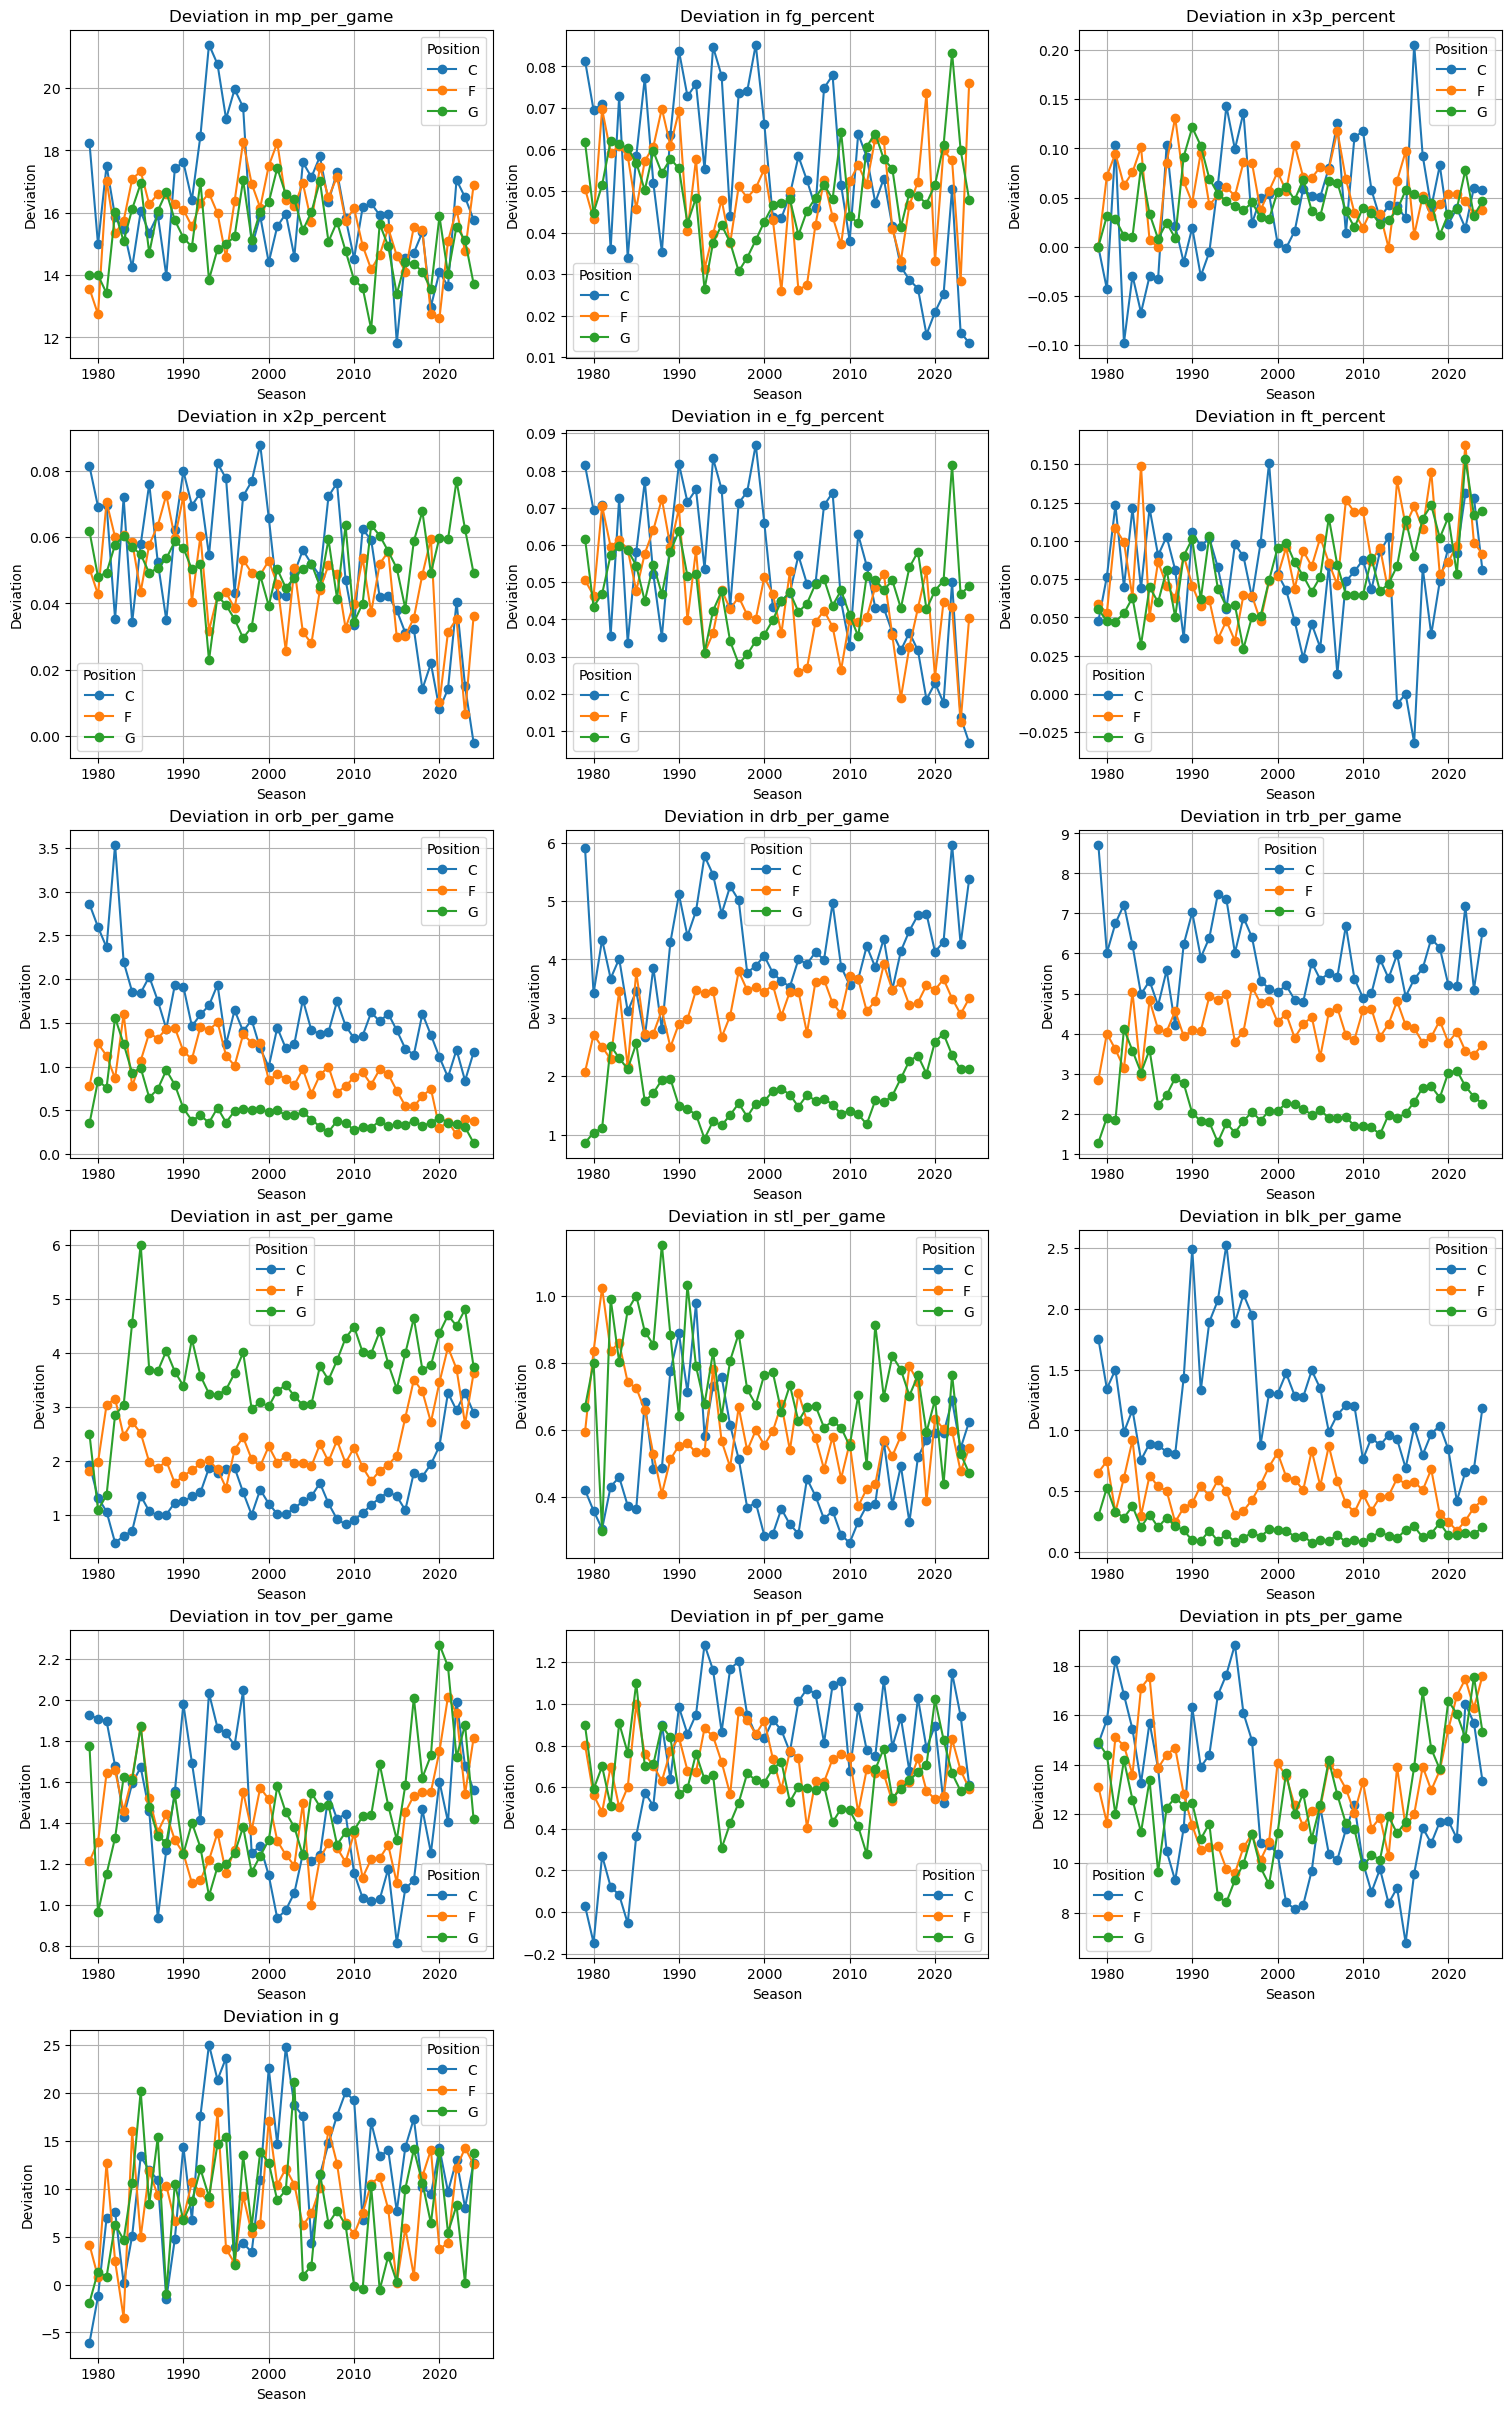

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

n_cols = 3
n_rows = -(-len(columns_to_compare) // n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4), constrained_layout=True)

axes = axes.flatten()

for idx, column in enumerate(columns_to_compare):
    ax = axes[idx]
    deviation[column].unstack().plot(kind='line', marker='o', ax=ax)
    ax.set_title(f"Deviation in {column}")
    ax.set_ylabel("Deviation")
    ax.set_xlabel("Season")
    ax.grid(True)
    ax.legend(title="Position")

for i in range(len(columns_to_compare), len(axes)):
    fig.delaxes(axes[i])

plt.show()

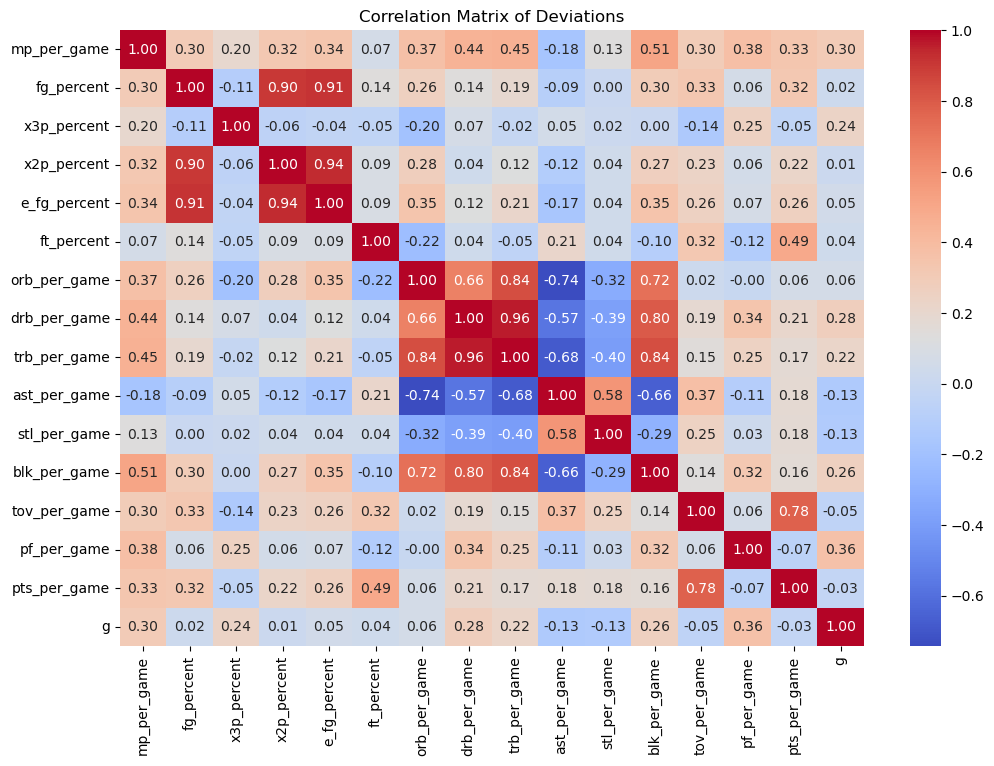

In [24]:
correlation = deviation.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Deviations")
plt.show()

In [25]:
# from sklearn.cluster import KMeans
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# deviation_filled = deviation.fillna(deviation.mean())
# deviation_scaled = scaler.fit_transform(deviation_filled)

# kmeans = KMeans(n_clusters=3, random_state=42)
# clusters = kmeans.fit_predict(deviation_scaled)

# deviation['Cluster'] = clusters
# deviation

In [26]:
era_comparison = deviation.groupby(['era', 'position']).mean()

positions = era_comparison.index.get_level_values('position').unique()

fig, axes = plt.subplots(len(positions), 1, figsize=(10, len(positions) * 4), sharex=True)

for idx, position in enumerate(positions):
    ax = axes[idx]
    position_data = era_comparison.loc[(slice(None), position), :].unstack(level='position')
    position_data.plot(ax=ax, marker='o', legend=False)
    ax.set_title(f"Deviation Trends by Era for Position: {position}")
    ax.set_xlabel("Era")
    ax.set_ylabel("Deviation")
    ax.grid(True)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.1), ncol=5)

plt.tight_layout(rect=[0, 0.1, 1, 0.95])
plt.show()


KeyError: 'era'

In [ ]:
from sklearn.linear_model import LogisticRegression

X = historical_data[columns_to_compare]  # Replace with relevant stat columns
y = historical_data['all_nba']  # 1 if All-NBA, 0 otherwise

model = LogisticRegression()
model.fit(X, y)

# Get feature importance
weights = model.coef_[0]
for stat, weight in zip(stat_columns, weights):
    print(f"{stat}: {weight}")

Emphasis per Positions

Team Success

Training
- choose model

Report